# Time Series Analysis - S&P 500 Index - 10 years 

The main goal of the Capstone Project is the evaluation of hybrid and stand-alone time-series predictive models using stock market data, such as SARIMA and Neural Networks (NN). 
In order to develop such models, the work will be carried by performing an analysis and meeting models requirements and assumptions. In addition, any pre-processing step or transformations would be exactly the same for all, focusing on consistency and fairness across every approach when comparing the results.   

**The present and first Jupyter will be composed by**: 

- Importing the data from Yahoo Finance; 
- Pre-Processing;
- EDA;
- Time Series Analysis; 


In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
from scipy import stats
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from math import sqrt

import warnings # filter warnings
warnings.filterwarnings('ignore')

The selected source is Yahoo Finances:

- Integration with Python;
- Open-Source data;
- Reliable Source;

The proposed period for the analysis in the project is 10 years of daily data. 

In [3]:
# Defines ticker symbol for S&P 500 index.
ticker_symbol = "^GSPC"

# Fetch historical data.
sp500_data = yf.download(ticker_symbol, start="2013-12-31", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


# Pre-Processing and EDA

- The analysis will be carried out using the closing index of the trading day.

In [4]:
# Selecting only the Close column (closing prices).
df = sp500_data['Close']

In [5]:
df.info() # Features and Info of the dataset.

<class 'pandas.core.series.Series'>
DatetimeIndex: 2517 entries, 2013-12-31 to 2023-12-29
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
2517 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [6]:
df.head() # First five rows of the dataset.

Date
2013-12-31    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
2014-01-07    1837.880005
Name: Close, dtype: float64

In [7]:
df.shape # Shape of the dataset (rows X columns). 

(2517,)

- The dataset, a time-series data, is composed by the Date (Datetime Index) and the Close (daily closing index). The series presents 2517 observations. 

In [8]:
df.describe() # Descriptive Statistics of the closing index.

count    2517.000000
mean     3005.423258
std       901.454132
min      1741.890015
25%      2124.199951
50%      2798.030029
75%      3906.709961
max      4796.560059
Name: Close, dtype: float64

- Further comments on statistical properties will be given after imputation technique. 

In [9]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
0


- As the count of statistics was the same as the number of observations, no missing values at this stage.  

In [10]:
# Check the frequency of the time series.
frequency = pd.infer_freq(df.index)

print("Frequency of the time series:", frequency) # Prints the frequency of the series.

Frequency of the time series: None


No frequency was detected in the time-series, thus business days ('b') will be the selected, due to the needs of the project.  
- Aligns with the chacteristics of the data (Stock market data), which is only open on business days. 


In [11]:
df = df.asfreq('b') # Sets the frequency to business days.

- Without any frequency, the original set did not included holidays and by setting to business days, it will generate nan values. 

In [12]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
92


- After setting the new frequency, the series presents 92 missing values (number of holidays throughout 10 years of interval).

In [13]:
# Checking if there's any consecutive missing values in the Close indexes. 
# Converting NaN checks to integers (1 for True, 0 for False).
nan_series = df.isna().astype(int)

# Rolling window size 3 and sum to identify consecutive NaNs.
consecutive_nans = nan_series.rolling(window=3).sum() == 3

# Check for any occurrence of more than two consecutive NaNs.
has_consecutive_nans = consecutive_nans.any()

print(f"Two consecutive NaNs in 'Close' column? {has_consecutive_nans}")

Two consecutive NaNs in 'Close' column? False


- Between the period of 10 years, 92 holidays were added (no values).
- No consecutive missing values (two holidays in a sequence does not exists). 
- Assuming that the close value of the last trading day will maintain until the following trading day.

Many options can be applied to fill the missing values (holidays) and each one of them have a trade off of pros and cons. Techniques using the next opening day to fill the previous, linear regression and others (depending on the performance). The selected approach to handle the missing values is the foward fill and the reasons relies on:

The S&P500 index does not suffers any change when the market is closed;
- It can reduce the amount of noise by not adding artificial data;
- It represents more accurate real-world scenario;

Other options such as back-fill using the open index of the next day could be considered. On one hand can present events that might impact the stock market, on the other hand it can introduce bias to the models, by "seing" future data.

In [14]:
# Forward fill NaN values in the 'Close' column.
df.fillna(method='ffill', inplace=True)

# Display the updated DataFrame with forward filled values.
display(df)

Date
2013-12-31    1848.359985
2014-01-01    1848.359985
2014-01-02    1831.979980
2014-01-03    1831.369995
2014-01-06    1826.770020
                 ...     
2023-12-25    4754.629883
2023-12-26    4774.750000
2023-12-27    4781.580078
2023-12-28    4783.350098
2023-12-29    4769.830078
Freq: B, Name: Close, Length: 2609, dtype: float64

In [15]:
# Check for missing values.
missing_values = df.isnull().sum()

# Print the number of missing values for each column.
print("Missing values:")
print(missing_values)

Missing values:
0


- After applying the forward-fill, the previous code shows that it was sucessfull, resulting in zero missing values. 

In [16]:
df.describe()

count    2609.000000
mean     3005.472863
std       901.733128
min      1741.890015
25%      2124.199951
50%      2793.899902
75%      3902.620117
max      4796.560059
Name: Close, dtype: float64

The statistical properties of the index suffered small changes compared to the scale of the data.

- Count: Originally the dataset was composed by 2517 rows and had an increased of 92, totalizing 2609 observations. 
- Mean: After the imputation the mean increased only 0.049 (3005.47), indicating that the central tendency did not suffer any change. 
- Standard Deviation (std): After handling the missing values, the std was not impacted (increased of 0.27). Also, the value 901.7 indicates that the index shows significant variability.
- Quartiles and median: The only changes were the median and the Q3, decreasing 4.

According to the properties, the imputation did not change the integrity of the data. 

## S&P500 Visual Analysis

The visual aspect of the series will provide further insights and the techniques to be used in this section are the:

- Lineplots will show the behaviour of the index throughout the course of 10 years.
- Histogram will present the distribution of the values. 
- Boxplots: will visualize the volatility and outliers year by year. 

The currently S&P 500 index format is not the best to generate visualizations, so the dataset will: 
- Transforming to dataframe: The dataset has series format, it needs to be changed to create better images. 
- Extracting Year: To obtain more insights, the year of the recorded date will be extracted to generate the boxplot per year as an example. 

In [17]:
# Creates a copy and converts the Series to a DataFrame.
df1 = df.to_frame()

# Creates a year column for grouping.
df1['Year'] = df1.index.year

# Display the first few rows of the data.
print(df1.head())

                  Close  Year
Date                         
2013-12-31  1848.359985  2013
2014-01-01  1848.359985  2014
2014-01-02  1831.979980  2014
2014-01-03  1831.369995  2014
2014-01-06  1826.770020  2014


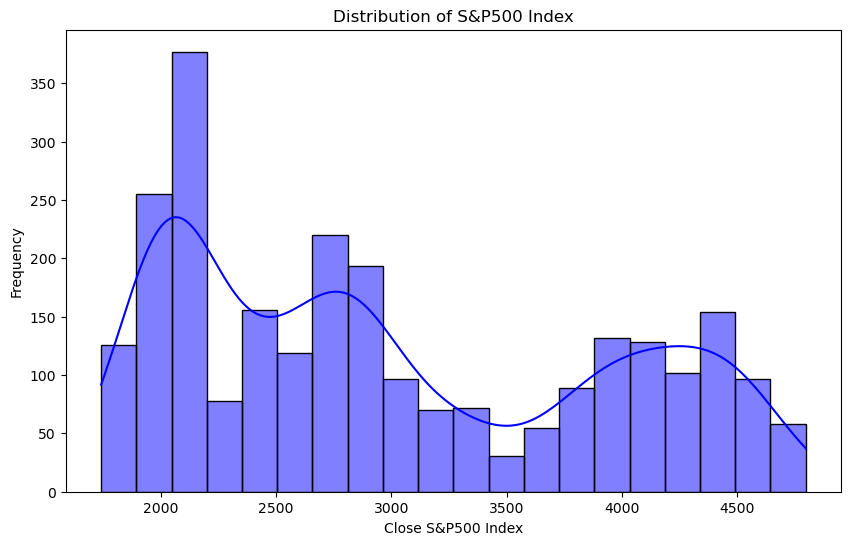

In [18]:
# Distribution plot of Close prices
plt.figure(figsize=(10, 6)) # Set fig size.
sns.histplot(df, bins=20, kde=True, color='blue') # Set bin size and color, add kde curve. 
plt.title('Distribution of S&P500 Index') # Add title.
plt.xlabel('Close S&P500 Index') # X-label.
plt.ylabel('Frequency') # Y-label.
plt.show() # Display the fig. 

- The histogram indicates that the index presents multimodal characteristics, where the KDE curve shows three different peaks. Despite trying different number of bins, multiple peaks were still present.
- During the recorded period, lower values (between 2000 and 3000) are more frequente than the higher values, indicating a right-skewed distribution.

**Obs**.: Models that follows the assumption that the data is normally distruibuted could present challenges. 

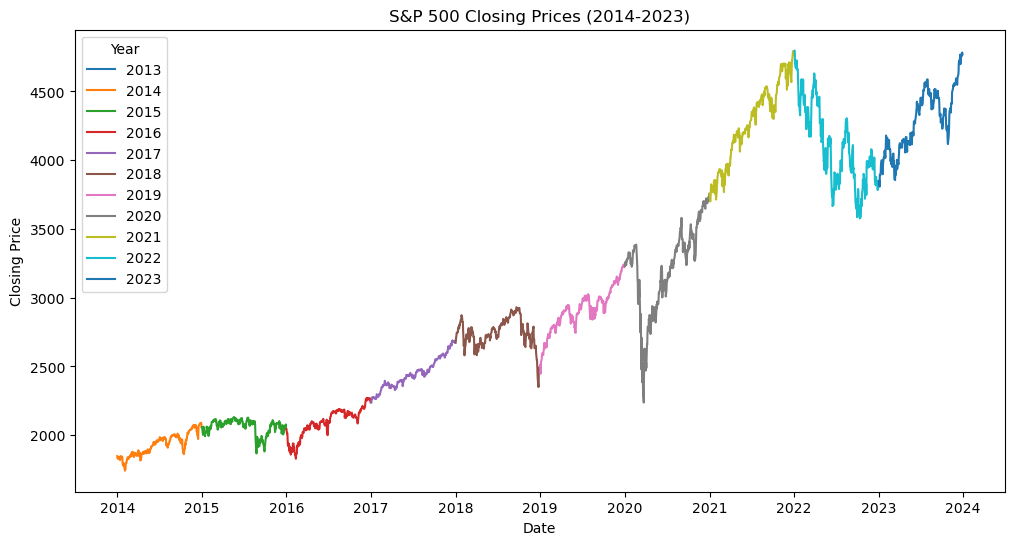

In [19]:
# Line Plot per Year
plt.figure(figsize=(12, 6)) # Sets fig size.
# Sets  the lineplot where the colors are based on the yeard, following the tab10 palette, providing clarity to the observer. 
sns.lineplot(data=df1, x=df1.index, y='Close', hue='Year', palette='tab10') 
plt.title('S&P 500 Closing Prices (2014-2023)') # Sets title.
plt.xlabel('Date') # Add label.
plt.ylabel('Closing Price') # Add label.
plt.legend(title='Year') # Adds legend (years). 
plt.show() # Display the fig. 

By observing the lineplot:
- The index presents an upward trend, the figures shows a long-term growth of the stocks. 
- In the recorded period, volatility is present, especially during crisis that can affect the economy (Health crisis started in 2019).
- The lineplot also does not show clear patterns. (indication of cyclical pattern, instead of seasonal).  

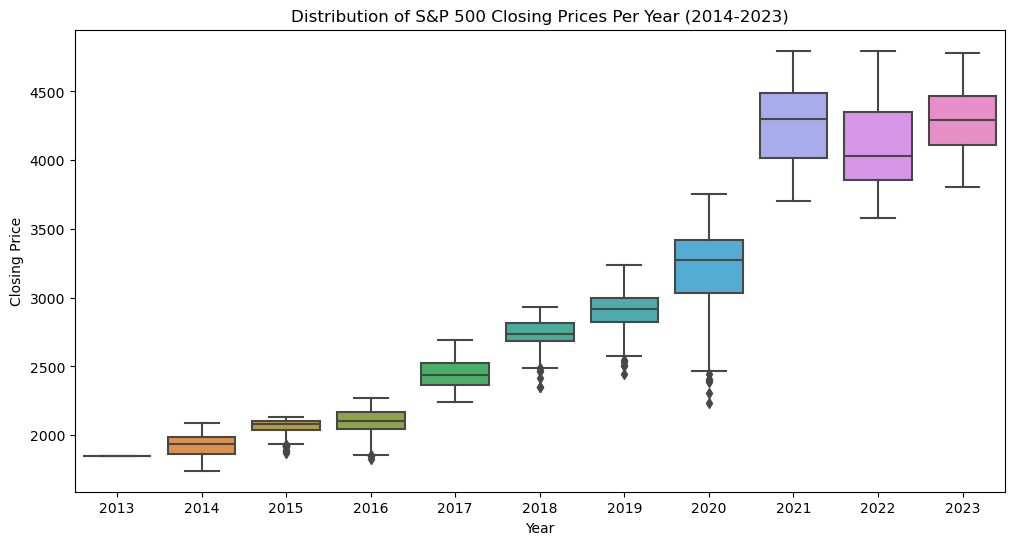

In [20]:
# Box Plot per Year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=df1)
plt.title('Distribution of S&P 500 Closing Prices Per Year (2014-2023)')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

The Boxplot per year shows that: 
- Like the lineplot it presents a upward trend. 
- The presence of outliers, especially in times of economical turmoil like the Covid Pandemic. High volatility.

#### Rolling Statistics

The periods to be used to analyse the rolling statistics according to its frequency:
- 5 days - a week of trading days.
- 21 days - a month of trading days.
- 63 days - quartely of trading days.
- 126 - one year of trading days.

**Note**: the rolling statistics were similiar to other values, so as the analysis, thus the display of the figure will be only for 21 days. 

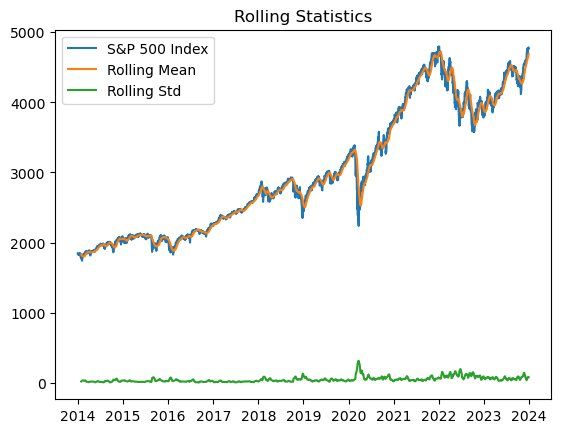

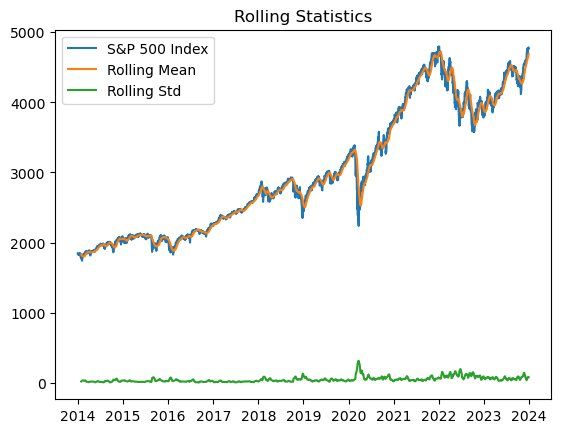

In [21]:
# Sets the window for a week.
rolling_mean = df.rolling(window=21).mean() 
rolling_std = df.rolling(window=21).std()
# Sets the lineplots into the same figure.
plt.plot(df, label='S&P 500 Index')
plt.plot(rolling_mean, label='Rolling Mean') # Add Labels.
plt.plot(rolling_std, label='Rolling Std') # Add Labels.
plt.legend() # Add the legends.
plt.title('Rolling Statistics') # Set title.
plt.show() # Show the fig.

# Stationarity check (one month of trading)
# Sets the window for a month.
rolling_mean = df.rolling(window=21).mean()
rolling_std = df.rolling(window=21).std()
# Sets the lineplots into the same figure.
plt.plot(df, label='S&P 500 Index')
plt.plot(rolling_mean, label='Rolling Mean') # Add Labels.
plt.plot(rolling_std, label='Rolling Std') # Add Labels.
plt.legend() # Add the legends.
plt.title('Rolling Statistics') # Set title.
plt.show() # Show the fig.

- Observing the rolling statistics (week and month), the rolling mean follows the index, showing a short-term tred. Whereas the rolling std remained low, but presents spikes after the Covid-19 breakout (higher volatility). 

### Seasonal Decomposition (Without transformation)

Both models, additive and multiplicative will be performed to check which one will better capture trends and seasonality (by observing the randomness of residuals. 

Seasonal Decomposition with Period = 126


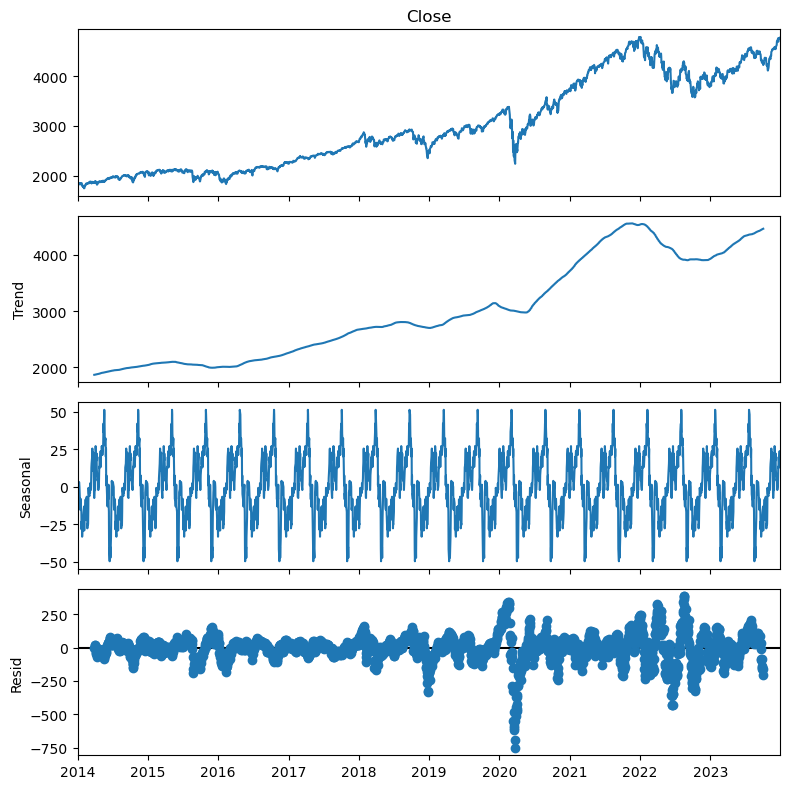

Seasonal Decomposition with Period = 63


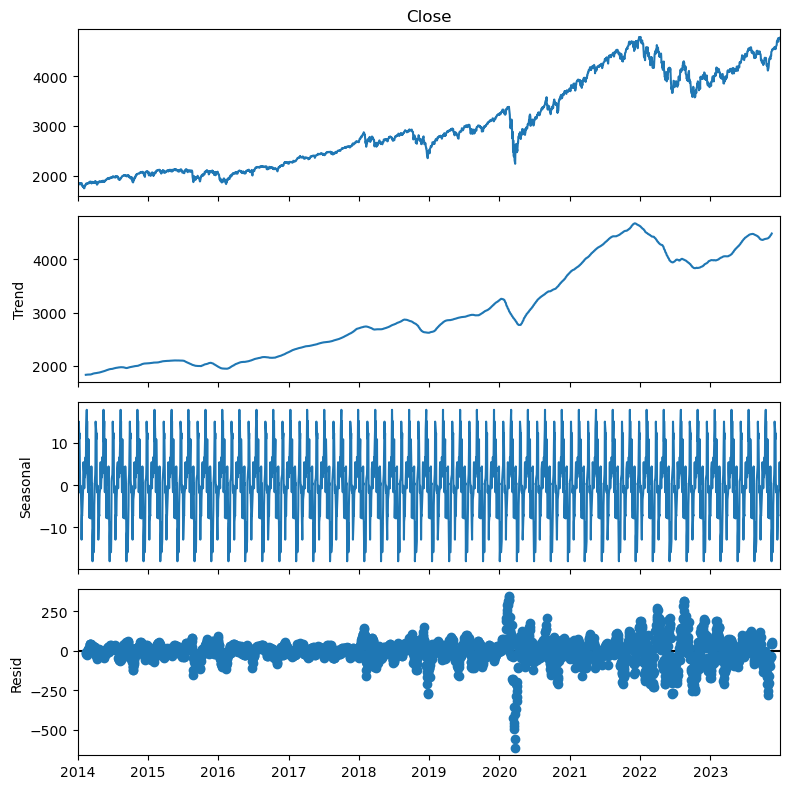

Seasonal Decomposition with Period = 21


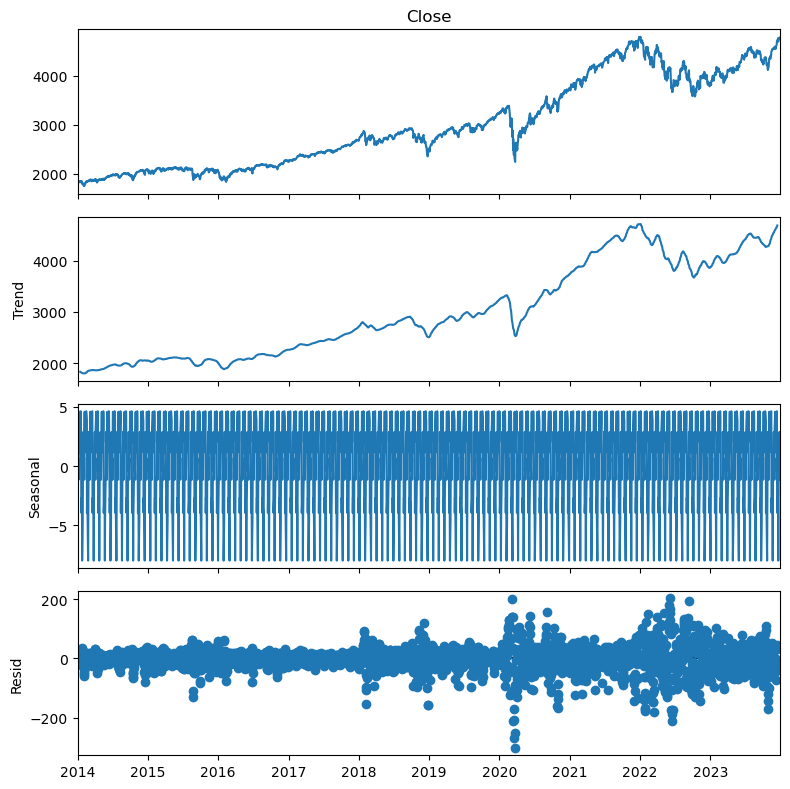

Seasonal Decomposition with Period = 5


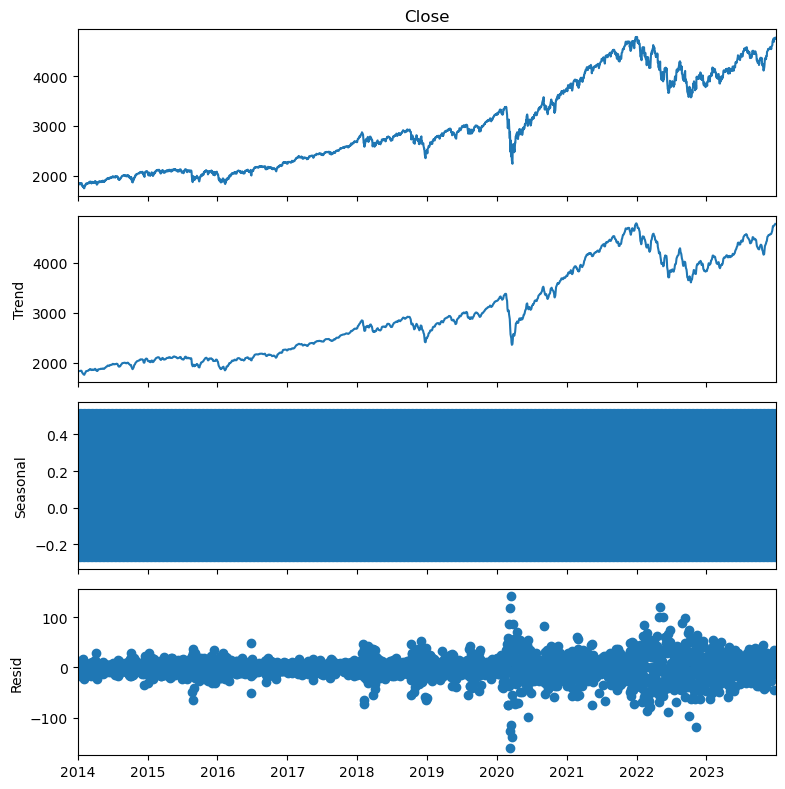

In [22]:
# Seasonal decompositions with different periods.
periods = [126, 63, 21, 5]  # Six months, Quarterly, Monthly, Weekly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df, model='additive', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

Seasonal Decomposition with Period = 126


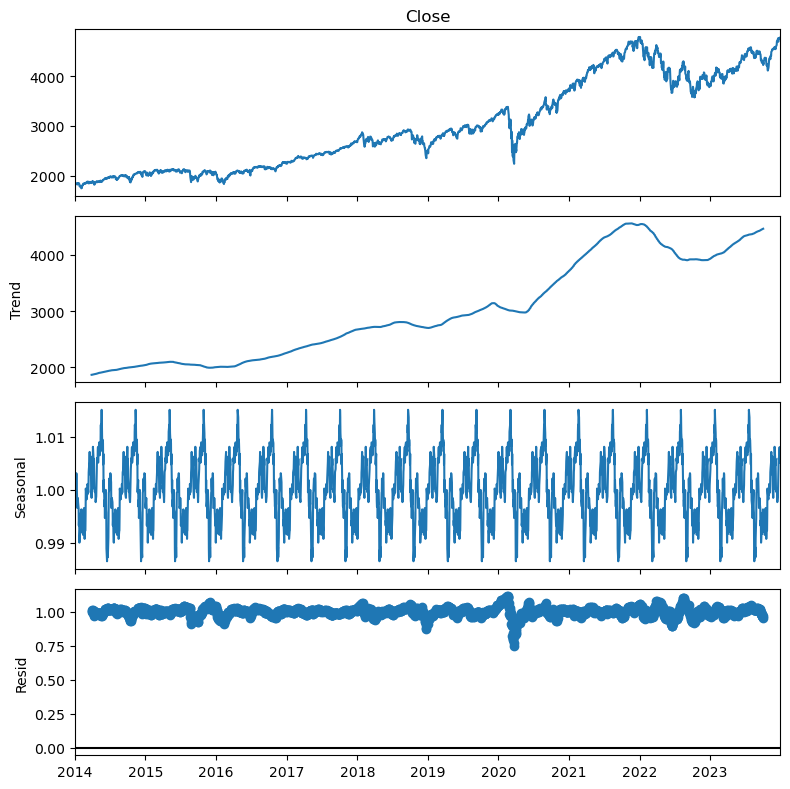

Seasonal Decomposition with Period = 63


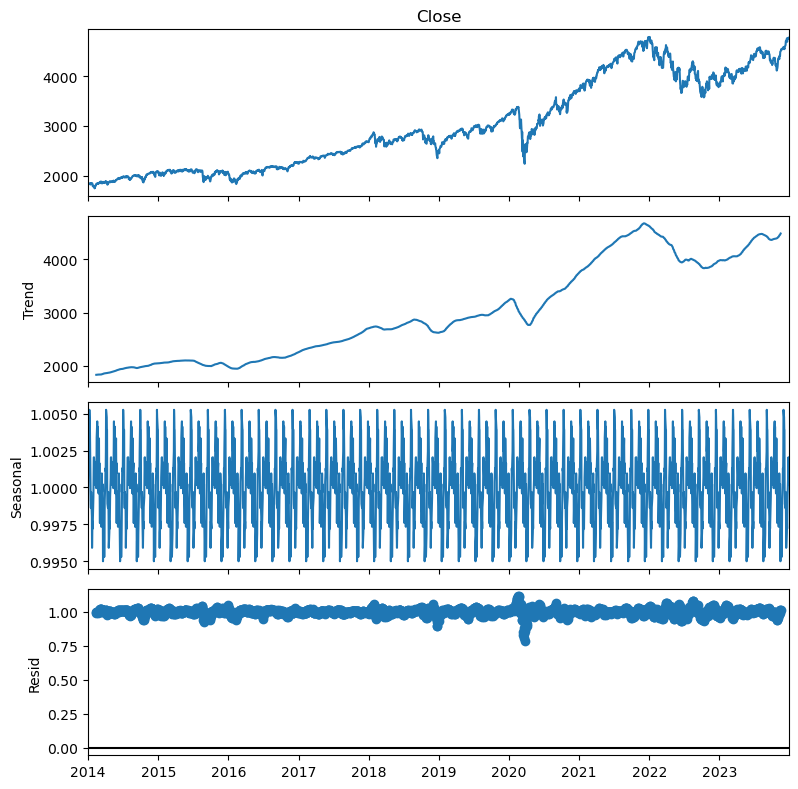

Seasonal Decomposition with Period = 21


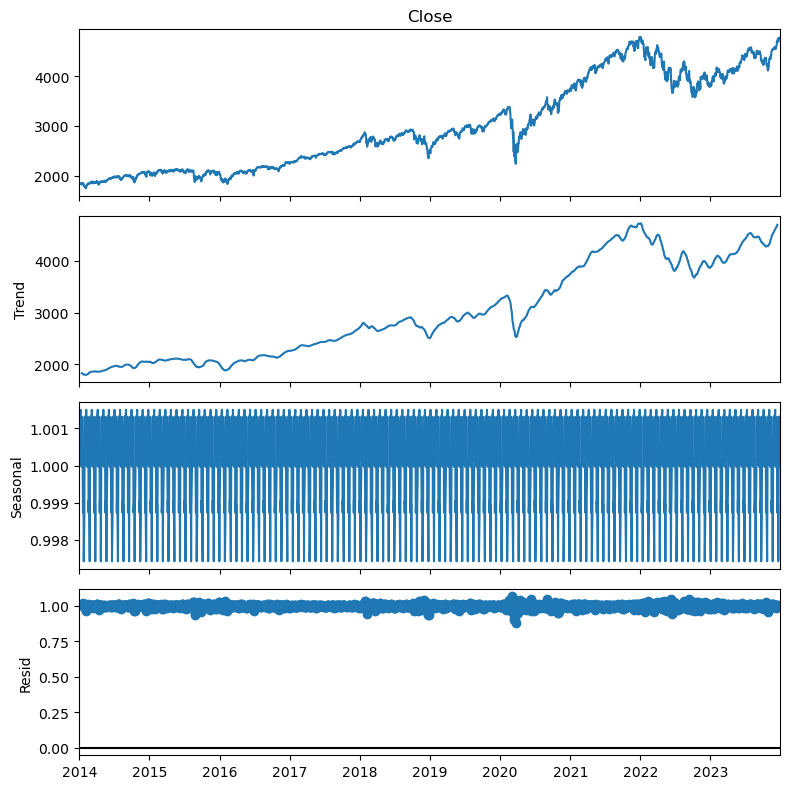

Seasonal Decomposition with Period = 5


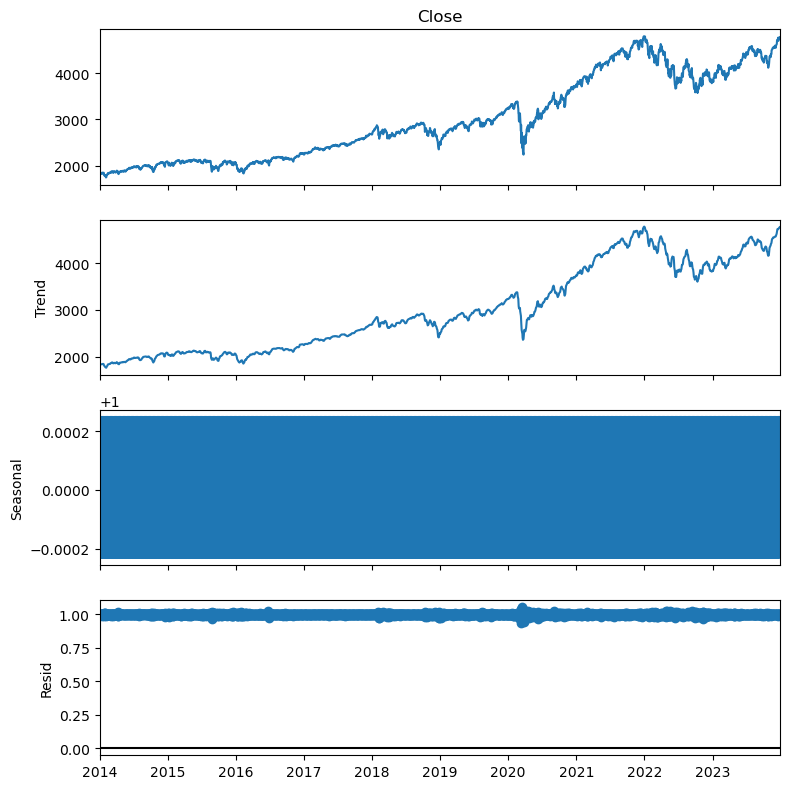

In [23]:
# Seasonal decompositions with different periods.
periods = [126, 63, 21, 5]  # Six months, Quarterly, Monthly, Weekly
# Function to generate the plots for all periods.
for period in periods:
    decompositions = seasonal_decompose(df, model='multiplicative', period=period)

    # Plotting the components of the decomposition
    plt.rcParams.update({'figure.figsize': (8,8)})
    print(f"Seasonal Decomposition with Period = {period}")
    decompositions.plot()
    plt.show()

According to the seasonal decompose (additive and multiplicative): 

- Both models shows a clear upward trend, indicating constant growth overtime, but presenting big drops, like when Covid-19 appeared (external events). 
- Seasonal variations is also observable when applying the multiplicative model. So, indicating that the seasonal variation of the S&P500 is not constant throughout time, but it might change proportionaly with the series. 
- Residuals in the multiplicative approach is less random and more aligned with the axis 1. Meanwhile, the additive has the residuals less aligned with its zero axis. Thus, the multiplicative method was able to better capture the trend and seasonal effects than the additive. 

Therefore, the decomposition of the series were better represented byt the multiplicative approach, meaning that more complex models like neural networks that could capture seasonal variations and likely yielding better performance.   

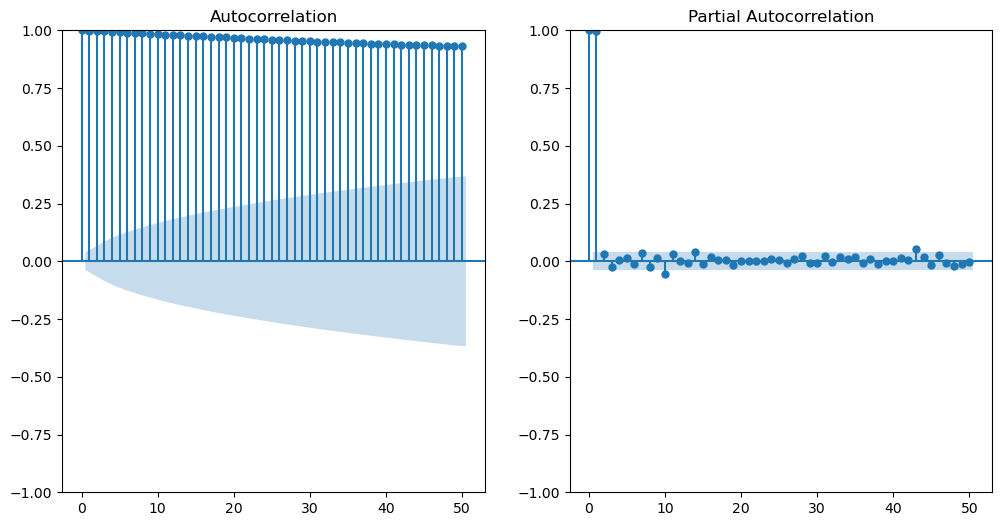

In [24]:
# ACF and PACF of log returns
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df, ax=plt.gca(), lags=50) # sets the acf plot. 
plt.subplot(122)
plot_pacf(df, ax=plt.gca(), lags=50) # sets the pacf plot. 
plt.show() # shows the plots

- The ACF correlation plot shows a strong correlation between its past values, in which can indicate that the series might not be stationary, because of the depency of previous values. 

### Stationarity Check

In [25]:
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.274939693479533
p-value: 0.9289793936532919
Critial Values:
   1%, -3.4328724587241686
Critial Values:
   5%, -2.862654426799674
Critial Values:
   10%, -2.567363249505311

KPSS Statistic: 7.951934
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Both tests shows that the series is not stationary. The ADF test determined that the p-value is way above 0.05, so as the critical value is greater than the 10, 5 and 1%. The KPSS test also shows the the statistic value is way above the others and the p-value has a low value of 0.01. Therefore, to perform time series forecasting, the index will have to be transformed to achieve stationarity.
A couple of techniques will be applied: 
- Log Returs: A model that is additive over time (a positive point for financial data) and has great chances to achieve stationarity. 
- Seasonal Differencing: With seasonal patters, the approach will attempt to remove seasonal patterns to achieve the objective. 
- Log transformation: With a upward trend and a constant growth, the series presents a high variance and the technique will aid to stabilize the variance. 

The approches will be evaluated in the forecasting stage, pointing which one has the lower metric scores. In addition, looking at consitency the data and pre-processing steps will be the same as performed in the present analysis. 